#Introduction:
The following notebook contains a BERT uncased model fine-tuned/trained all 3 Datasets (D1, D2 and D3). This model will be called ALL_BERT and corresponds to model 10 from the accompanying article. The model will be validated on unseen test data from all three datasets.


# Importing relevant packages

In [1]:
# Importing packages, libraries and modules
import numpy as np
import pandas as pd
import json
import zipfile
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.util import ngrams
import torch
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.2 MB/s eta 0:00:00


# Importing Reddit Data

All Datasets will be randomly cut down to contain 25,000 values, treating the datasets similar to class. Thus, The model will have a balanced dataset class/type and will be less likely to overfit to any particular Dataset.

In [2]:
# Reddit data
reddit_data = pd.read_csv('REDDIT-train-balanced-sarcasm.csv')
reddit_data

# Checking for NaN/missing values in the training data
missing_data = reddit_data.isnull()
missing_data= reddit_data[reddit_data.isnull().any(axis=1)]
missing_data.head()

# Removing rows with missing data
reddit_data = pd.concat([reddit_data, missing_data, missing_data]).drop_duplicates(keep=False)
reddit_data

# Reducing the df to contain necessary data only
reddit_data = reddit_data[['comment','label']]
reddit_data

# Shuffling the data and reducing it to roughly 25,000 instances
reddit_data = reddit_data.sample(n=25000, random_state=1)
reddit_data

,comment,label
163863,Hehe Head,0
600885,Proof global warming doesn't exist,1
803456,Democracy didn't start this The Fire was start...,0
804718,The fact they offered very little new info and...,0
605274,"""The ban on cargo shorts is officially lifted""...",1
...,...,...
974416,Meaning he's probably a fat gamer who faps a l...,1
88707,Well google told me i'm overweight at 210 poun...,1
503005,"As a trained educator myself, I'm sure there a...",1
804500,It's vintage.,0


# Importing Twitter Data

In [3]:
# Twitter training data
twitter_train = pd.read_csv('TWITTER-train.csv')
twitter_train.head()

# Twitter testing data
twitter_test = pd.read_csv('TWITTER-test.csv')
twitter_test.head()

# Combining training and testing datasets to form a larger dataset
twitter_data = pd.concat([twitter_train , twitter_test ])
twitter_data

# Checking for NaN/missing values in the training data
missing_data = twitter_data.isnull()
missing_data= twitter_data[twitter_data.isnull().any(axis=1)]
missing_data.head()

# Removing rows with missing data
twitter_data = pd.concat([twitter_data, missing_data, missing_data]).drop_duplicates(keep=False)
twitter_data

# Removing iorony and figurative tweets
twitter_data = twitter_data[~twitter_data['class'].isin(['figurative', 'irony'])]
twitter_data

# Renaming columns
twitter_data .columns = ['comment', 'label']
twitter_data

# Shuffling the data and reducing it to roughly 25,000 instances
twitter_data = twitter_data.sample(n=25000, random_state=1)
twitter_data

# Create a dictionary for mapping
label_map = {'sarcasm': 1, 'regular': 0}

# Apply the mapping to the 'label' column
twitter_data['label'] = twitter_data['label'].map(label_map)
twitter_data

,comment,label
69729,"Now that Giroud is out for dead, please sign B...",1
60502,Deadly #fake #Viagra: Online #pharmacies suspe...,0
47262,He logged into the ice http://t.co/cMoqRi1i14 ...,0
76065,The human body has 7trillion nerves &amp; some...,1
68833,Nothing like being ignored 😍 #sarcasm,1
...,...,...
6113,Its not #GlobalWarming Y'all #sarcasm http://t...,1
76088,Gargling salt water is exactly how I wanted to...,1
63740,Aww Gordon hit the wall...so sad! #Sarcasm,1
78288,The referee has the game under perfect control...,1


# Importing Headlines Data

In [4]:
# Extracting Headlines dataset
def extract_sarcasm_dataset(file_name):
    data = []

    # open the zip file in read mode
    with zipfile.ZipFile(file_name, 'r') as z:
        # get the name of the first file in the archive
        file_in_zip = z.namelist()[0]

        # open the file
        with z.open(file_in_zip) as f:
            for line in f:
                # parse each line as a JSON record
                record = json.loads(line.decode("utf-8"))

                # extract the record and append it to data list
                data.append(record)

    # convert the list of dictionaries to a DataFrame
    news_data = pd.DataFrame(data)

    return news_data

# print the first 5 rows of the DataFrame to check the data
news_data = extract_sarcasm_dataset('Sarcasm_Headlines_Dataset.json.zip')
news_data.head()

# Reducing the df to contain necessary data only
news_data = news_data[['headline','is_sarcastic']]
news_data

# Renaming columns
news_data.columns = ['comment', 'label']
news_data

# Shuffling the data and reducing it to roughly 25,000 instances
news_data = news_data.sample(n=25000, random_state=1)
news_data

,comment,label
21661,r.e.m.'s children still hoping parents will ge...,1
6023,what wealth isn't,0
15345,"7+ reasons why bisexual, pansexual, fluid, and...",0
7915,bradley cooper looks unrecognizable for new role,0
13951,south carolina refuses to remove confederate f...,1
...,...,...
22335,a new what??,0
6543,how pessimism can help you lose weight,0
18768,10 million fans killed off in sopranos season ...,1
1348,everyone in friend group drinking solely so th...,1


# Aggregating all Datasets to create D123 dataset

In [5]:
# concatenate the dataframes
D13_data = pd.concat([news_data, reddit_data])
# shuffle the new dataframe
D13_data = D13_data.sample(frac=1, random_state=1)
D13_data

# concatenate the dataframes
D123_data = pd.concat([D13_data, twitter_data])

# shuffle the new dataframe
D123_data = D123_data.sample(frac=1, random_state=1)
D123_data

,comment,label
169489,Everything has been invented in China.,1
54729,Once again @MCRMetrolink your service fails me...,0
5194,new blog piece on woody allen to settle everyt...,1
20542,where's the ref? fifa -- a sports body playing...,0
22733,41 photos of presidential pets over time,0
...,...,...
8747,republicans are shocked (!) that they've nomin...,0
3924,porn actress very nearly appears to enjoy ejac...,1
56420,Strike crisis worsens as 14m students sent hom...,0
56601,StumbleUpon perfect time http://t.co/fmRRJhB9p...,0


# Tokenizing and Encoding D123 data

In [6]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
# Tokenize the comments and encode the labels
D123_input_ids = []
D123_attention_masks = []
D123_labels = D123_data['label'].values.astype(int)

for comment in D123_data['comment']:
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens = True,
        max_length = 200,
        pad_to_max_length = False,
        padding='max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
    )
    D123_input_ids.append(encoded_dict['input_ids'])
    D123_attention_masks.append(encoded_dict['attention_mask'])

D123_input_ids = torch.cat(D123_input_ids, dim=0)
D123_attention_masks = torch.cat(D123_attention_masks, dim=0)
D123_labels = torch.tensor(D123_labels)

# Creating Training and Validation dataloaders for the D123 data

In [8]:
# Split data into training and validation sets
D123_train_inputs, D123_validation_inputs, D123_train_labels, D123_validation_labels = train_test_split(D123_input_ids, D123_labels, random_state=42, test_size=0.2)
D123_train_masks, D123_validation_masks = train_test_split(D123_attention_masks, random_state=42, test_size=0.2)

# Create the DataLoader for our training set
D123_train_data = TensorDataset(D123_train_inputs, D123_train_masks, D123_train_labels)
D123_train_sampler = RandomSampler(D123_train_data) # Data Loaded in a random order
D123_train_dataloader = DataLoader(D123_train_data, sampler=D123_train_sampler, batch_size=32, shuffle=False)

# Create the DataLoader for our validation set
D123_validation_data = TensorDataset(D123_validation_inputs, D123_validation_masks, D123_validation_labels)
D123_validation_sampler = SequentialSampler(D123_validation_data) # Data Loaded in the same order
D123_validation_dataloader = DataLoader(D123_validation_data, sampler=D123_validation_sampler, batch_size=32, shuffle=False)

## BERT Model

In [9]:
# Load BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 1,
    output_attentions = False,
    output_hidden_states = False,
)
# Print the model
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
# Specify GPU as device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Specifying Loss function and Optimizer

In [11]:
# Specify loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)  # adjust learning rate (lr) as needed

# Training Script

In [12]:
# Function to Train BERT
def train_model(model, train_dataloader, loss_function, optimizer, device, epochs):
    train_loss_values = []  # List to store training loss values
    train_accuracy_values = []  # List to store training accuracy values
    train_f1_values = []  # List to store training F1 score values

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_predictions = []
        total_labels = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Move batch to GPU
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            # Zero the gradients
            model.zero_grad()

            # Perform forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            # Compute loss
            loss = loss_function(outputs.logits, b_labels.unsqueeze(-1).float())
            total_loss += loss.item()

            # Perform backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute accuracy
            preds = torch.sigmoid(outputs.logits)
            preds = (preds > 0.5).long() # Can Fine-Tune the Treshold
            total_correct += (preds.squeeze() == b_labels).sum().item()

            # Store predictions and labels for F1 Score
            total_predictions.extend(preds.squeeze().cpu().numpy().flatten())
            total_labels.extend(b_labels.cpu().numpy().flatten())

        # Calculate average loss over all batches
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_values.append(avg_train_loss)

        # Calculate accuracy
        train_accuracy = total_correct / len(train_dataloader.dataset)
        train_accuracy_values.append(train_accuracy)

        # Calculate F1 Score
        train_f1 = f1_score(np.array(total_labels), np.array(total_predictions))
        train_f1_values.append(train_f1)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {(train_accuracy*100):.2f}%, F1 Score: {(train_f1*100):.2f}%')

    # Plotting the curves
    plt.figure(figsize=(18, 5))

    # Plotting training loss curve
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), train_loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    # Plotting training accuracy curve
    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), train_accuracy_values, label='Training Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Curve')
    plt.legend()

    # Plotting training F1 score curve
    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), train_f1_values, label='Training F1 Score', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training F1 Score Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training BERT on D13 Training Data

Epoch [1/15], Loss: 0.4583, Training Accuracy: 76.48%, F1 Score: 75.73%
Epoch [2/15], Loss: 0.3299, Training Accuracy: 83.97%, F1 Score: 83.39%
Epoch [3/15], Loss: 0.2995, Training Accuracy: 85.60%, F1 Score: 85.06%
Epoch [4/15], Loss: 0.2788, Training Accuracy: 86.62%, F1 Score: 86.09%
Epoch [5/15], Loss: 0.2656, Training Accuracy: 87.39%, F1 Score: 86.91%
Epoch [6/15], Loss: 0.2516, Training Accuracy: 88.22%, F1 Score: 87.78%
Epoch [7/15], Loss: 0.2402, Training Accuracy: 88.65%, F1 Score: 88.24%
Epoch [8/15], Loss: 0.2296, Training Accuracy: 89.29%, F1 Score: 88.89%
Epoch [9/15], Loss: 0.2193, Training Accuracy: 89.88%, F1 Score: 89.53%
Epoch [10/15], Loss: 0.2099, Training Accuracy: 90.45%, F1 Score: 90.13%
Epoch [11/15], Loss: 0.1989, Training Accuracy: 90.89%, F1 Score: 90.59%
Epoch [12/15], Loss: 0.1890, Training Accuracy: 91.47%, F1 Score: 91.20%
Epoch [13/15], Loss: 0.1824, Training Accuracy: 91.75%, F1 Score: 91.48%
Epoch [14/15], Loss: 0.1735, Training Accuracy: 92.31%, F1 S

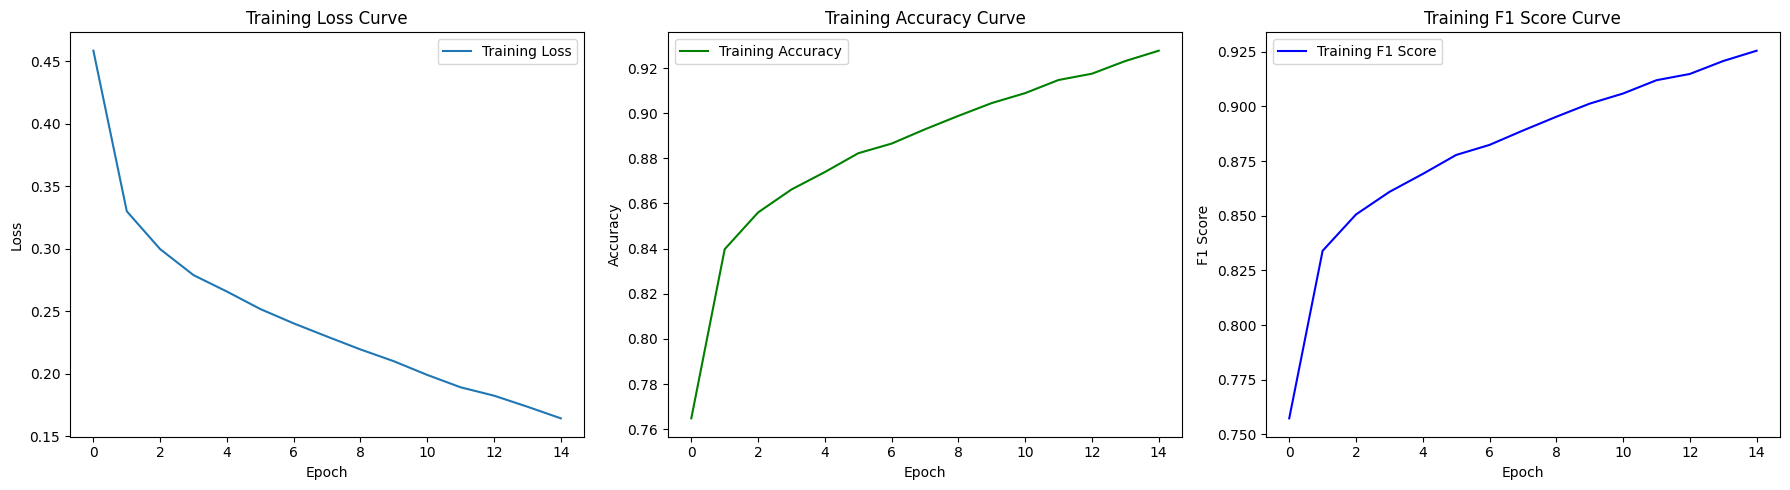

In [13]:
train_model(model, D123_train_dataloader, loss_function, optimizer, device, 15)

# Validation Script

In [14]:
# Function to Evaluate BERT
def evaluate_model(model, validation_dataloader, loss_function, device):
    model.eval()
    val_loss_values = []  # List to store validation loss values
    val_accuracy_values = []  # List to store validation accuracy values
    val_f1_values = []  # List to store validation F1 score values
    total_predictions = []  # List to store all predictions
    total_labels = []  # List to store all labels

    for batch in validation_dataloader:
        # Move batch to GPU
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        # Perform forward pass and compute predictions
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Compute loss
        loss = loss_function(outputs.logits, b_labels.unsqueeze(-1).float())
        val_loss_values.append(loss.item())

        # Compute accuracy
        preds = torch.sigmoid(outputs.logits)
        preds = (preds > 0.5).long()
        total_correct = (preds.squeeze() == b_labels).sum().item()
        val_accuracy = total_correct / len(b_labels)
        val_accuracy_values.append(val_accuracy)

        # Store predictions and labels for F1 Score
        total_predictions.extend(preds.squeeze().cpu().numpy().flatten())
        total_labels.extend(b_labels.cpu().numpy().flatten())

        # Calculate F1 Score for the batch
        val_f1 = f1_score(b_labels.cpu().numpy().flatten(), preds.squeeze().cpu().numpy().flatten())
        val_f1_values.append(val_f1)

    # Calculate average loss and average accuracy over all batches
    avg_val_loss = sum(val_loss_values) / len(validation_dataloader)
    avg_val_accuracy = sum(val_accuracy_values) / len(validation_dataloader)

    # Calculate F1 Score
    total_val_f1 = f1_score(np.array(total_labels), np.array(total_predictions))

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {(avg_val_accuracy*100):.2f}%, F1 Score: {(total_val_f1*100):.2f}%')

    # Plotting the validation accuracy curve
    plt.figure(figsize=(12, 5))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(len(val_accuracy_values)), val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()

    # Plotting F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(range(len(val_f1_values)), val_f1_values, label='Validation F1 Score')
    plt.xlabel('Batch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Validation on D123 Unseen Data

Validation Loss: 0.3029, Validation Accuracy: 87.60%, F1 Score: 87.09%


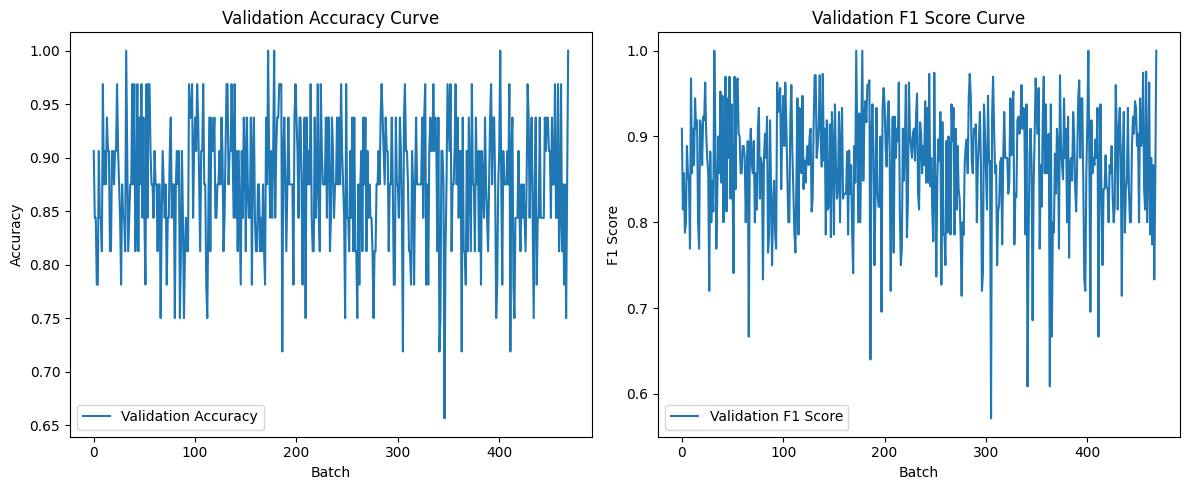

In [15]:
evaluate_model(model, D123_validation_dataloader, loss_function, device)